In [1]:
import os
import ast
import sys
src_dir = os.path.join('..', 'src')
sys.path.append(os.path.abspath(src_dir))
import numpy as np
import tensorflow as tf

from embbeding import get_embbeding_layer
from vectorizer import load_vectorizer
from data import get_dataset
from dataprep import split, preprocess

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
data = get_dataset()
data.is_oc = data.is_oc.astype(np.float32)
data.is_self = data.is_self.astype(np.float32)
train, test = split(data)
train, test = preprocess(train, test)

../../data/datasets/data_0.99.csv


In [3]:
train

,score,title_tokens,body_tokens,body_emojis,title_emojis,is_oc,is_self,sin_time,cos_time,sin_date,...,title_capital_letters_ratio,body_capital_letters_count,body_capital_letters_ratio,body_urls_count,title_emoji_count,title_emojis_ratio,body_emoji_count,body_emojis_ratio,title_sentiment,body_sentiment
15975,0,run starting buy bakd,go yet blocked next buy one,,,0.0,1.0,-0.940424,-0.340003,0.463550,...,0.423,0.004419,0.216,0.000000,0.000000,0.000,0.000000,0.000,0.0000,0.2746
30135,25,trading buy bb,,,💎 ✋,0.0,1.0,-0.922021,-0.387139,0.448229,...,0.312,0.000000,0.000,0.000000,0.016393,0.087,0.000000,0.000,0.0000,0.0000
25377,149,retards yolo inside hedge dd og,life within class left handed realized funds w...,💎 🙌 💎 🙌 🐒 🦍,,0.0,1.0,-0.999627,-0.027297,0.538005,...,0.275,0.015267,0.031,0.000000,0.000000,0.000,0.002591,0.004,0.4278,0.6891
28296,104,,,,💎 ✊ 🦍 ✊ 💎 💎 ✊ 🦍 ✊ 💎 🎮 🚀 🚀 🚀,0.0,0.0,-0.767517,-0.641029,0.552435,...,0.000,0.000000,0.000,0.000000,0.114754,0.636,0.000000,0.000,0.0000,0.0000
7676,0,nokia porns first oh loss,,,,0.0,0.0,-0.924579,0.380991,0.566702,...,0.276,0.000000,0.000,0.000000,0.000000,0.000,0.000000,0.000,-0.3182,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3043,583,squeeze following media gme guide short journa...,companies literally lawsuit comment websites e...,,,0.0,1.0,-0.541862,0.840467,0.523416,...,0.188,0.043391,0.024,0.148148,0.000000,0.000,0.000000,0.000,0.0000,-0.7264
6525,34,squeeze gme skeptic retarded learning,faster seriously exp count information basical...,🥳 🤑 😭 🤷 ♂ 🤤,,0.0,1.0,-0.633331,-0.773881,0.566702,...,0.071,0.075934,0.040,0.074074,0.000000,0.000,0.002591,0.001,-0.6808,0.9813
13154,2,price gme limit,,,,0.0,1.0,-0.842984,-0.537939,0.463550,...,0.138,0.000000,0.000,0.000000,0.000000,0.000,0.000000,0.000,0.0000,0.0000
36190,1,nokia gme next,yolo way nok,,,0.0,1.0,-0.981795,0.189945,0.448229,...,0.235,0.001607,0.222,0.000000,0.000000,0.000,0.000000,0.000,0.0000,0.2732


In [4]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("score")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    
    return ds
    
train_ds = dataframe_to_dataset(train)
validation_ds = dataframe_to_dataset(test)

In [5]:
train_ds = train_ds.batch(32)
validation_ds = validation_ds.batch(32)

In [6]:
def encode_text_feature(feature, name, dataset):
    vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=100, output_mode='int')

    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
    
    vectorizer.adapt(feature_ds)
    encoded_feature = vectorizer(feature)
    
    return encoded_feature

In [49]:
def embbed_vectorized_text(feature):
    return layers.Embedding(20000, 64)(feature)

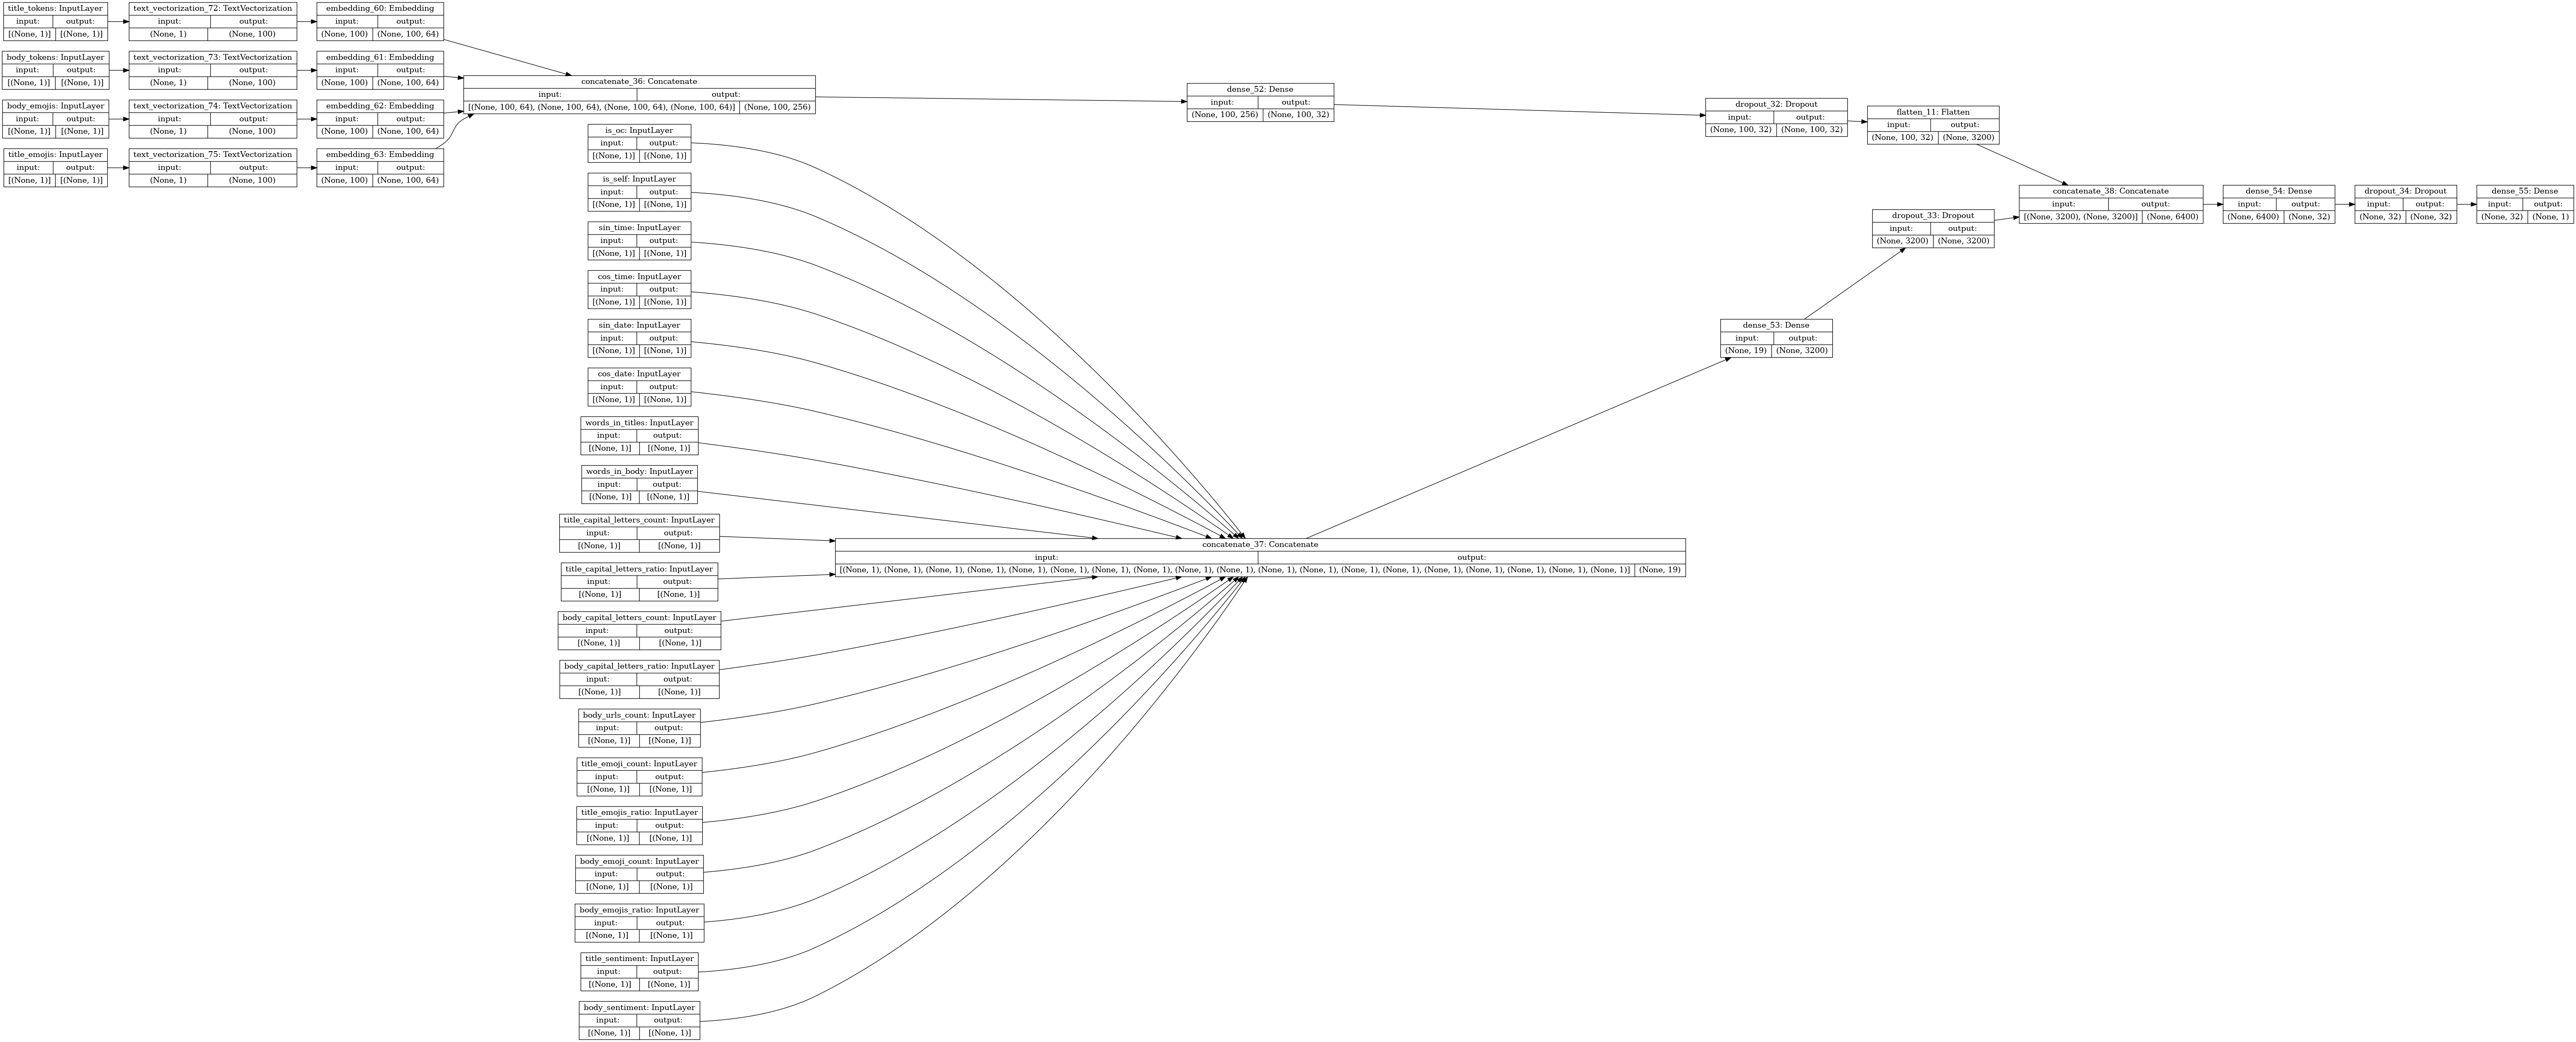

In [53]:
# Text features
title_tokens = keras.Input(shape=(1,), name="title_tokens", dtype=tf.string)
body_tokens = keras.Input(shape=(1,), name="body_tokens", dtype=tf.string)
body_emojis = keras.Input(shape=(1,), name="body_emojis", dtype=tf.string)
title_emojis = keras.Input(shape=(1,), name="title_emojis", dtype=tf.string)

# Numerical features
is_oc = keras.Input(shape=(1,), name="is_oc", dtype="float64")
is_self = keras.Input(shape=(1,), name="is_self", dtype="float64")
sin_time = keras.Input(shape=(1,), name="sin_time", dtype="float64")
cos_time = keras.Input(shape=(1,), name="cos_time", dtype="float64")
sin_date = keras.Input(shape=(1,), name="sin_date", dtype="float64")
cos_date = keras.Input(shape=(1,), name="cos_date", dtype="float64")
words_in_titles = keras.Input(shape=(1,), name="words_in_titles", dtype="float64")
words_in_body = keras.Input(shape=(1,), name="words_in_body", dtype="float64")
title_capital_letters_count = keras.Input(shape=(1,), name="title_capital_letters_count", dtype="float64")
title_capital_letters_ratio = keras.Input(shape=(1,), name="title_capital_letters_ratio", dtype="float64")
body_capital_letters_count = keras.Input(shape=(1,), name="body_capital_letters_count", dtype="float64")
body_capital_letters_ratio = keras.Input(shape=(1,), name="body_capital_letters_ratio", dtype="float64")
body_urls_count = keras.Input(shape=(1,), name="body_urls_count", dtype="float64")
title_emoji_count = keras.Input(shape=(1,), name="title_emoji_count", dtype="float64")
title_emojis_ratio = keras.Input(shape=(1,), name="title_emojis_ratio", dtype="float64")
body_emoji_count = keras.Input(shape=(1,), name="body_emoji_count", dtype="float64")
body_emojis_ratio = keras.Input(shape=(1,), name="body_emojis_ratio", dtype="float64")
title_sentiment = keras.Input(shape=(1,), name="title_sentiment", dtype="float64")
body_sentiment = keras.Input(shape=(1,), name="body_sentiment", dtype="float64")

all_inputs = [
    title_tokens,
    body_tokens,
    body_emojis,
    title_emojis,
    is_oc,
    is_self,
    sin_time,
    cos_time,
    sin_date,
    cos_date,
    words_in_titles,
    words_in_body,
    title_capital_letters_count,
    title_capital_letters_ratio,
    body_capital_letters_count,
    body_capital_letters_ratio, 
    body_urls_count,
    title_emoji_count,
    title_emojis_ratio,
    body_emoji_count,
    body_emojis_ratio,
    title_sentiment,
    body_sentiment
]

# Vectorize text features
title_tokens_vectorized = encode_text_feature(title_tokens, 'title_tokens', train_ds)
body_tokens_vectorized = encode_text_feature(body_tokens, 'body_tokens', train_ds)
body_emojis_vectorized = encode_text_feature(body_emojis, 'body_emojis', train_ds)
title_emojis_vectorized = encode_text_feature(title_emojis, 'title_emojis', train_ds)

# Embedd vectorized text
title_tokens_embbeded = embbed_vectorized_text(title_tokens_vectorized)
body_tokens_embbeded = embbed_vectorized_text(body_tokens_vectorized)
body_emojis_embbeded = embbed_vectorized_text(body_emojis_vectorized)
title_emojis_embbeded = embbed_vectorized_text(title_emojis_vectorized)

all_text_features = layers.concatenate(
    [
        title_tokens_embbeded,
        body_tokens_embbeded,
        body_emojis_embbeded,
        title_emojis_embbeded,
    ]
)

y = layers.Dense(32, activation="relu")(all_text_features)
y = layers.Dropout(0.5)(y)
y = layers.Flatten()(y)


all_numerical_features = layers.concatenate(
    [
        is_oc,
        is_self,
        sin_time,
        cos_time,
        sin_date,
        cos_date,
        words_in_titles,
        words_in_body,
        title_capital_letters_count,
        title_capital_letters_ratio,
        body_capital_letters_count,
        body_capital_letters_ratio, 
        body_urls_count,
        title_emoji_count,
        title_emojis_ratio,
        body_emoji_count,
        body_emojis_ratio,
        title_sentiment,
        body_sentiment,
    ]
)

x = layers.Dense(3200, activation="relu")(all_numerical_features)
x = layers.Dropout(0.5)(x)

all_ = layers.concatenate([y, x])
z = layers.Dense(32, activation="relu")(all_)
z = layers.Dropout(0.5)(z)
output = layers.Dense(1, activation="linear")(z)
model = keras.Model(all_inputs, output)
model.compile("adam", loss="mean_absolute_error")
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [54]:
model.fit(train_ds, epochs=50, validation_data=validation_ds)

Epoch 1/50
1095/1095 [==============================] - 39s 35ms/step - loss: 969.2763 - val_loss: 1194.1819
Epoch 2/50
1095/1095 [==============================] - 38s 35ms/step - loss: 960.8696 - val_loss: 1192.6730
Epoch 3/50
1095/1095 [==============================] - 38s 35ms/step - loss: 955.2602 - val_loss: 1190.9465
Epoch 4/50
1095/1095 [==============================] - 38s 35ms/step - loss: 948.9503 - val_loss: 1191.4186
Epoch 5/50
1095/1095 [==============================] - 38s 35ms/step - loss: 943.3726 - val_loss: 1191.8436
Epoch 6/50
1095/1095 [==============================] - 38s 35ms/step - loss: 937.3430 - val_loss: 1192.8414
Epoch 7/50
1095/1095 [==============================] - 38s 35ms/step - loss: 932.4709 - val_loss: 1192.8665
Epoch 8/50
1095/1095 [==============================] - 38s 35ms/step - loss: 925.0209 - val_loss: 1194.1052
Epoch 9/50
1095/1095 [==============================] - 37s 34ms/step - loss: 919.0082 - val_loss: 1194.4625
Epoch 10/50
1095/10

In [65]:
[int(x) for x in model.predict(validation_ds)[:10]]

[18, 15, 18, 14, 14, 4044, 24, 17, 4019, 89]

In [66]:
[x for x in test.score[:10]]

[6, 6, 7, 19, 11, 123, 2602, 11, 65, 389]